In [1]:
import alphashape
import shapely.geometry as geometry
from shapely.geometry import Polygon
from descartes import PolygonPatch
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import shape
from shapely.ops import transform
import pyproj
from functools import partial
from datetime import datetime, timedelta

## Define some functions

In [2]:
def ow_lag(date):
    # Read from forward
    f_fw = netCDF4.Dataset('../data/forward/new_%s.nc' %date, 'r')
    f_bw = netCDF4.Dataset('../data/backward/new_%s.nc' %date, 'r')

    f_ieig1 = f_fw.variables['ieig1']
    f_reig1 = f_fw.variables['reig1']
    b_ieig1 = f_bw.variables['ieig1']
    b_reig1 = f_bw.variables['reig1']

    ieig1 = f_ieig1[:,:,:] + b_ieig1[:,:,:]
    reig1 = f_reig1[:,:,:] + b_reig1[:,:,:]

    ow_lag = ieig1[:,:,:] - b_ieig1[:,:,:]
    # Flush
    f_fw = None; f_bw = None; f_ieig1 = None; f_reig1 = None; b_ieig1 = None; b_reig1 = None
    ieig1 = None; reig1 = None

    return ow_lag

In [3]:
def next_time(startdate,days=0,hours=0,minutes=0,seconds=0):
    """Find next time for calculation"""
    sdate = datetime.strptime(startdate, '%Y%m%d_%H')
    date = sdate + timedelta(days=days, hours=hours)
    date = datetime.strftime(date, '%Y%m%d_%H')
    return date

def duration(startdate,enddate):
    """Time duration in hours"""
    sdate = datetime.strptime(startdate, '%Y%m%d_%H')
    edate = datetime.strptime(enddate  , '%Y%m%d_%H')
    delta = edate - sdate
#     if isinstance(delta, np.timedelta64):
#         return delta.astype(timedelta).total_hours() / 60.
    return delta.days, delta.seconds

In [4]:
# Define projection to calculate area
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

In [5]:
# Date
sdate = "20170713_06"
edate = "20170713_06"

dur_day, dur_sec = duration(sdate,edate)

dur_hr = dur_sec // (60*60) + dur_day * 24

ndate = dur_hr // 6

date = sdate

It should be put in a loop of date later, but since now I just wanna check a little bit

In [66]:
    df = pd.read_csv("../CLU_VORT/labels/labellist2d_%s.csv" %date)
    df.columns = [col.replace(' ', '') for col in df.columns]

In [68]:
df

,level,value,number_of_labels,label
0,1000.0,0.0,13,1
1,1000.0,0.0,13,2
2,1000.0,0.0,13,3
3,1000.0,0.0,13,4
4,1000.0,0.0,13,5
...,...,...,...,...
6775,800.0,20.5,1,1
6776,800.0,20.6,1,1
6777,800.0,20.7,1,1
6778,800.0,20.8,1,1


In [69]:
    ref_levs = df.groupby(["level"]).count().index.to_numpy()

In [70]:
ref_levs

array([ 400.,  500.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
       1000.])

In [71]:
    # Check file 1
    f = netCDF4.Dataset("../CLU_VORT/nc_files/cc2d_%s.nc" %date,"r")

In [72]:
    lons = f.variables['longitude'][:]
    lats = f.variables['latitude'][:]
    levs = f.variables['level'][:]

    nlev = levs.shape[0]
    nlon = lons.shape[0]
    nlat = lats.shape[0]
    print(nlon,nlat,nlev)

221 121 11


In [73]:
print(levs)

[1000.  900.  850.  800.  750.  700.  650.  600.  500.  400.  300.]


In [74]:
# Get OW_LAG
ow_lag = ow_lag(date)

TypeError: 'MaskedArray' object is not callable

In [75]:
# Sample var
ilev = 1
        sub_df=df[df["level"] == levs[ilev]]


In [76]:
values = sub_df.groupby(["value"]).count().index.to_numpy()

In [77]:
# for ival,val in enumerate(values):    
#     print(val)
#     var = f.variables["labels_cc2d_%05.2f" %val][ilev,:,:]

In [78]:
val = values[10]

In [79]:
var = f.variables["labels_cc2d_%05.2f" %val][ilev,:,:]

In [81]:
label = sub_df[sub_df["value"] == val]["label"]

In [93]:
sub_df

,level,value,number_of_labels,label
13,900.0,0.0,13,1
14,900.0,0.0,13,2
15,900.0,0.0,13,3
16,900.0,0.0,13,4
17,900.0,0.0,13,5
...,...,...,...,...
6742,900.0,19.3,1,1
6746,900.0,19.4,1,1
6750,900.0,19.5,1,1
6754,900.0,19.6,1,1


1.000	    1	100.545	  2.222	    216774308628.140	2.629889e-06
1.000	    2	121.806	  0.111	      3485269223.940	1.970222e-06


1.000	    7	116.831	  2.022	     17438740851.627	4.861060e-07


1.000	    8	132.707	 10.147	   3574094700490.895	-1.925470e-06


1.000	   14	102.803	  4.467	     35737788819.868	2.914724e-06


1.000	   18	 92.466	 14.575	    784775690167.690	1.626973e-06


1.000	   19	108.893	 16.075	   2501826054099.563	1.441021e-06
1.000	   24	104.679	 15.321	     13250518300.525	0.000000e+00


1.000	   25	 99.349	 18.568	      6537896016.142	2.183712e-06
1.000	   27	 99.392	 19.830	     11117604866.388	-1.089781e-07


1.000	   28	139.480	 24.748	   1071292324165.024	1.169770e-06


1.000	   43	120.906	 27.868	    192790842769.067	2.455260e-06


1.000	   47	109.089	 28.520	    124644415428.082	5.622733e-07


1.000	   51	105.305	 29.236	     77654669388.613	-1.076684e-06


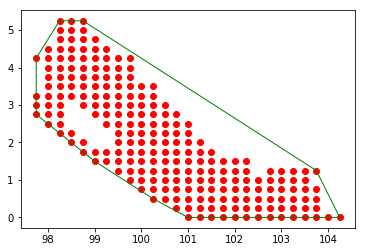

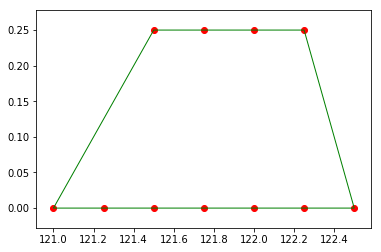

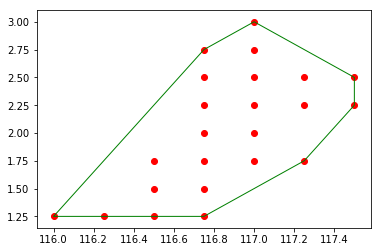

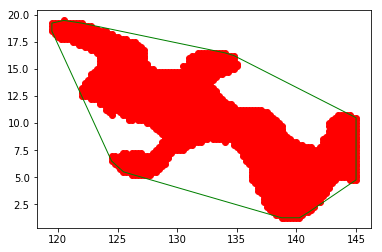

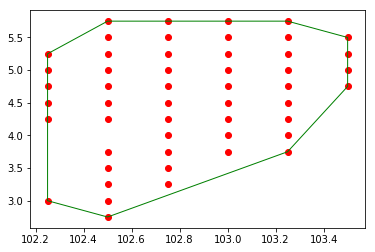

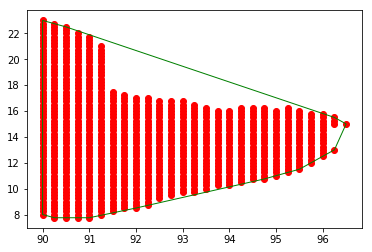

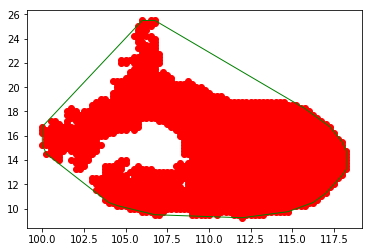

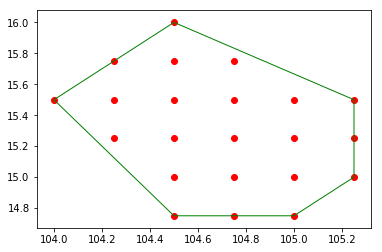

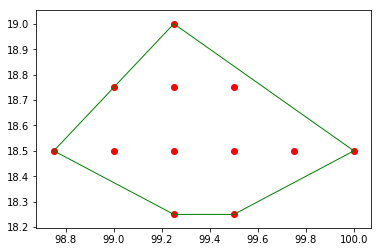

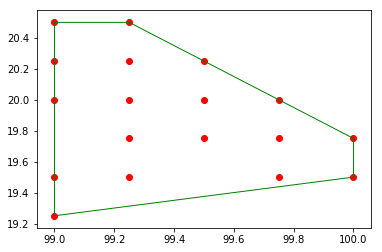

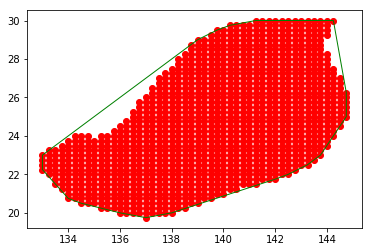

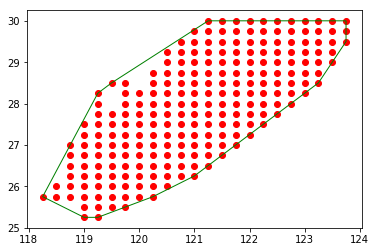

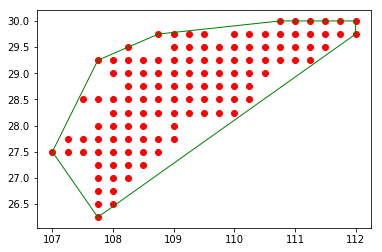

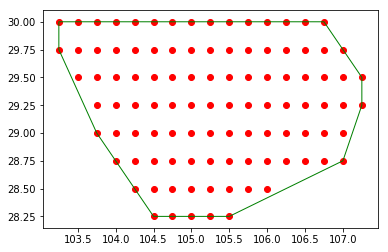

In [90]:
for ilabel in label:
        ilat,ilon = np.where(var == ilabel)
        
        latind_1 = lats[ilat]
        lonind_1 = lons[ilon]
         
        points = np.zeros([len(latind_1),2])
        for ipt in range(len(latind_1)):
            points[ipt,0] = lonind_1[ipt]
            points[ipt,1] = latind_1[ipt]
        
        
        alpha = 0.95 * alphashape.optimizealpha(points,max_iterations=100)
    
        hull = alphashape.alphashape(points, alpha)
    
    fig, ax = plt.subplots()
    ax.scatter(points[:,0], points[:,1], color='red')
    ax.add_patch(PolygonPatch(hull, fill=False, color='green'))
    
    hull_lons,hull_lats = hull.exterior.coords.xy
    hull_ilon = np.searchsorted(lons,hull_lons)
    hull_ilat = np.searchsorted(lats,hull_lats)
            
    # Output centroids and area
    hull_centx = hull.centroid.x
    hull_centy = hull.centroid.y
#   hull_area = hull.area # in square degrees

    s = shape(hull)
    hull_area = transform(proj, s).area
            #
    
    try:
        min_owlag = np.nanmin([x for x in ow_lag[ilev,hull_ilat,hull_ilon] if x != 0])
    except ValueError:   # raised if min_owlag is empty
        min_owlag = 0
            
    print('{:>5.3f}\t{:>5d}\t{:>7.3f}\t{:>7.3f}\t{:>20.3f}\t{:e}'
         .format(val,ilabel,hull_centx,hull_centy,hull_area,min_owlag))
#          file = open(r"cluster_%s.dat" %date, "a+"))
            
            
    # Start storing to file
            
            
            
    # Flush
    latind_1 = None; lonind_1 = None; ilat = None; ilon = None
    points = None; hull = None; hull_pts = None; alpha = None;
    hull_lons = None; hull_lats = None; hull_ilon = None; hull_ilat = None